/var/folders/3n/c2cyvjmd52585bcd83mjw9dw0000gp/T/ipykernel_57426/3032608636.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("NVDA", interval=interval, start=start, end=end, progress=False)


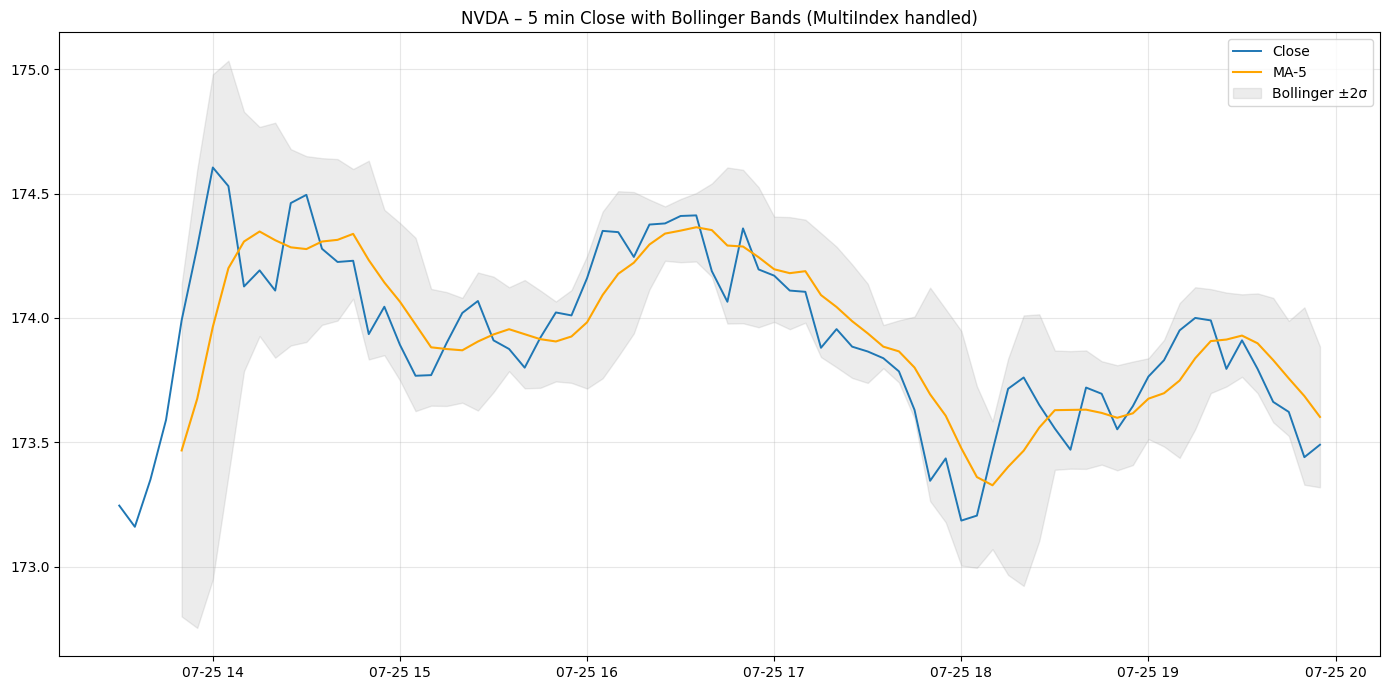

In [11]:
import yfinance as yf
import pandas as pd

def fetch_nvda(interval="1d", start=None, end=None):
    """
    Download NVDA prices, flatten MultiIndex columns if present,
    and return a clean DataFrame ready for analysis.

    Parameters
    ----------
    interval : str
        Valid yfinance interval (e.g., "1d", "5m", "1h").
    start, end : str or None
        ISO-formatted dates ("YYYY-MM-DD"); pass None for yfinance defaults.

    Returns
    -------
    pd.DataFrame
        DataFrame with flat columns: ["Open","High","Low","Close","Adj Close","Volume"]
        indexed by datetime.
    """
    df = yf.download("NVDA", interval=interval, start=start, end=end, progress=False)

    # --- 1. Handle possible MultiIndex on columns ---
    # yfinance returns a MultiIndex (field, ticker) if group_by="ticker" is implicit.
    if isinstance(df.columns, pd.MultiIndex):
        # Option A – drop the outer level (works when only one ticker):
        df = df.droplevel(1, axis=1)
        # If you ever request multiple tickers, use .xs() or reshape differently.

    # --- 2. Ensure numeric dtype and monotonic index ---
    df = df.apply(pd.to_numeric, errors="coerce")
    df = df[~df.index.duplicated()].sort_index()

    # Optional: drop rows that are entirely NaN (can happen on holidays / partial days)
    df.dropna(how="all", inplace=True)

    return df

# ---------- EXAMPLE USAGE ----------
if __name__ == "__main__":
    import datetime, matplotlib.pyplot as plt

    # Yesterday’s intraday data (use 5-minute bars for reliability)
    today = datetime.date.today()
    yesterday = today - datetime.timedelta(days=1)

    data = fetch_nvda(interval="5m",
                      start=str(yesterday),
                      end=str(today))

    # Quick Bollinger-band demo on the flattened data
    window = 5
    data["MA5"] = data["Close"].rolling(window).mean()
    data["STD"] = data["Close"].rolling(window).std()
    data["Upper"] = data["MA5"] + 2*data["STD"]
    data["Lower"] = data["MA5"] - 2*data["STD"]

    # Plot to verify everything aligns
    plt.figure(figsize=(14,7))
    plt.plot(data.index, data["Close"], label="Close", lw=1.4)
    plt.plot(data.index, data["MA5"],  label="MA-5", color="orange")
    plt.fill_between(data.index, data["Upper"], data["Lower"],
                     color="grey", alpha=0.15, label="Bollinger ±2σ")
    plt.title("NVDA – 5 min Close with Bollinger Bands (MultiIndex handled)")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


In [18]:
print(data)

Price                           Close        High         Low        Open  \
Datetime                                                                    
2025-07-25 13:30:00+00:00  173.245300  173.925003  172.964996  173.615005   
2025-07-25 13:35:00+00:00  173.160004  173.604996  172.970001  173.244995   
2025-07-25 13:40:00+00:00  173.350006  173.449997  173.000000  173.160004   
2025-07-25 13:45:00+00:00  173.589996  173.779999  173.339996  173.488800   
2025-07-25 13:50:00+00:00  173.990097  174.159897  173.399994  173.585007   
...                               ...         ...         ...         ...   
2025-07-25 19:35:00+00:00  173.794998  173.990005  173.764999  173.899994   
2025-07-25 19:40:00+00:00  173.662292  173.880005  173.630005  173.789993   
2025-07-25 19:45:00+00:00  173.621994  173.759995  173.589996  173.669998   
2025-07-25 19:50:00+00:00  173.439896  173.809998  173.330002  173.630005   
2025-07-25 19:55:00+00:00  173.490005  173.600006  173.250000  173.434998   